# Base Modelling

Were going to explore some base models to see if any are powerful enough to learn the subtleties of our data

These base models will serve as a benchmark for when we dive into Neural Networks.

Table of Contents:<a id="Contents"></a>
* [PCA Plot](#pcaplot)
* [Base Logistic Regression](#baselogreg)
* [SVM](#svm)
* [Random Forest](#rndmfr)
* [Weighted Logistic Regression](#weightlogreg)
* [Optimized Random Forest](#oprndmfr)
* [Best Model Evaluation](#modeleval)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_score, make_scorer, recall_score, f1_score, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../data/complete_df.csv')

In [5]:
X = df.drop(columns=['suitable_investment', 'ath_marketcap', 'growth']).select_dtypes(include=['number', 'bool'])
y = df['suitable_investment']

X = X.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11, stratify=y)

In [6]:
print(f'Our target class accounts for {y_train.sum() / len(y_train)}% of our train data')
print(f'Our target class accounts for {y_test.sum() / len(y_test)}% of our test data')

Our target class accounts for 0.011168557935495423% of our train data
Our target class accounts for 0.01114617605586517% of our test data


Let's start by scaling our data

In [7]:
scalerminmax = MinMaxScaler()

scalerminmax.fit(X_train)

X_train_mm_scaled = scalerminmax.transform(X_train)
X_test_mm_scaled = scalerminmax.transform(X_test)

### PCA<a id="pcaplot"></a>
<p><a href="#Contents" style="font-size: 12px;">Back to Table of Contents</a></p>

Let's start with a PCA plot to see if there are any clear clusters

In [39]:
my_PCA = PCA()
my_PCA.fit(X_train_mm_scaled)

print(f"Variance captured by PC1: {my_PCA.explained_variance_[0]: 0.3f}")
print(f"Variance captured by PC2: {my_PCA.explained_variance_[1]: 0.3f}")

print(f"Proportion of variance captured by PC1: {my_PCA.explained_variance_ratio_[0]: 0.3f}")
print(f"Proportion of variance captured by PC2: {my_PCA.explained_variance_ratio_[1]: 0.3f}")

Variance captured by PC1:  0.852
Variance captured by PC2:  0.574
Proportion of variance captured by PC1:  0.238
Proportion of variance captured by PC2:  0.160


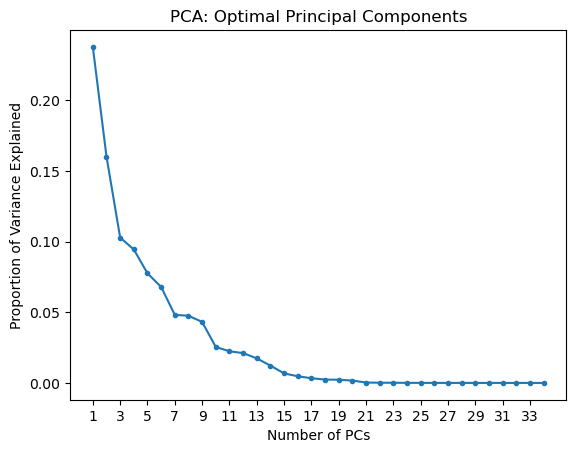

In [40]:
expl_var = my_PCA.explained_variance_ratio_

plt.figure()
plt.plot(range(1, len(expl_var) + 1), expl_var, marker='.')
plt.xlabel('Number of PCs')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1, len(expl_var) + 1, 2))
plt.title('PCA: Optimal Principal Components')
plt.show()

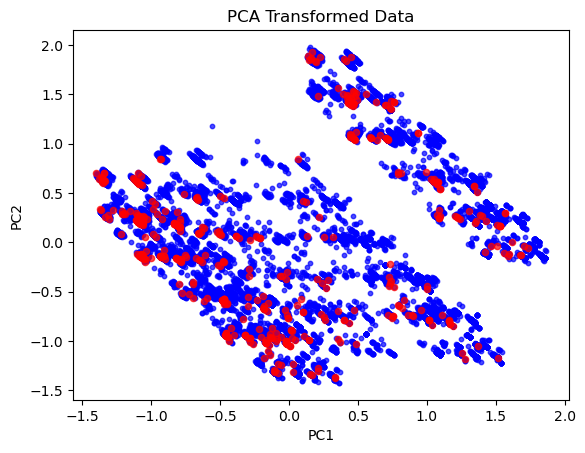

In [47]:
X_PCA = my_PCA.transform(X_train_mm_scaled)
X_PCA.shape

class_0_indices = (y_train == 0)
class_1_indices = (y_train == 1)

plt.scatter(X_PCA[class_0_indices, 0], X_PCA[class_0_indices, 1], c='blue', s=10, alpha=0.7, label='Class 0')
plt.scatter(X_PCA[class_1_indices, 0], X_PCA[class_1_indices, 1], c='red', s=20, alpha=0.7, label='Class 1')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Transformed Data')

plt.show()

No clear clustering behaviour here to seperate target class from the negative class.

we will continue modelling with our raw scaled data

### Base Logistic Regression<a id="baselogreg"></a>
<p><a href="#Contents" style="font-size: 12px;">Back to Table of Contents</a></p>

In [10]:
logistic_model_0 = LogisticRegression() #C=1 by default
logistic_model_0.fit(X_train, y_train)
y_pred_log0 = logistic_model_0.predict(X_test)

cf_matrix_log0 = confusion_matrix(y_test, y_pred_log0)
cf_df_log0 = pd.DataFrame(
    cf_matrix_log0, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

print(classification_report(y_test, y_pred_log0))
cf_df_log0

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14727
           1       0.00      0.00      0.00       166

    accuracy                           0.99     14893
   macro avg       0.49      0.50      0.50     14893
weighted avg       0.98      0.99      0.98     14893



,Predicted Negative,Predicted Positive
True Negative,14687,40
True Positive,166,0


99% accuracy seems great but quite misleading. 

Our model wasn't able to identify any of the target class data. This is why working with scaled and weighted data is important when dealing with such a severe class imbalance.

### SVM<a id="svm"></a>
<p><a href="#Contents" style="font-size: 12px;">Back to Table of Contents</a></p>

In [7]:
SVM_model = LinearSVC()
SVM_model.fit(X_train_mm_scaled, y_train)

print(f"The TRAIN classification accuracy is: {SVM_model.score(X_train_mm_scaled, y_train)}")

The TRAIN classification accuracy is: 0.9888314420645046


In [8]:
y_pred_svm = SVM_model.predict(X_test)
cf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
cf_df_svm = pd.DataFrame(
    cf_matrix_svm, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

print(classification_report(y_test, y_pred_svm))
cf_df_svm

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     14727
           1       0.01      0.31      0.02       166

    accuracy                           0.72     14893
   macro avg       0.50      0.52      0.43     14893
weighted avg       0.98      0.72      0.83     14893



,Predicted Negative,Predicted Positive
True Negative,10704,4023
True Positive,115,51


Precision is too low in our SVM

our weighted f1 score is 0.83 ~ let's see if we can improve

### Random Forest<a id="rndmfr"></a>
<p><a href="#Contents" style="font-size: 12px;">Back to Table of Contents</a></p>

In [9]:
random_forest_model = RandomForestClassifier(random_state=2) #n_estimators and max_depth at default
random_forest_model.fit(X_train_mm_scaled, y_train)
rf_predictions = random_forest_model.predict(X_test)

cf_matrix_rf = confusion_matrix(y_test, rf_predictions)
cf_df_rf = pd.DataFrame(
    cf_matrix_rf, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

print(classification_report(y_test, rf_predictions))
cf_df_rf

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14727
           1       0.05      0.01      0.02       166

    accuracy                           0.99     14893
   macro avg       0.52      0.50      0.51     14893
weighted avg       0.98      0.99      0.98     14893



,Predicted Negative,Predicted Positive
True Negative,14691,36
True Positive,164,2


Improved precision, but low recall

Our weighted f1 score has improved to .98

Let's see how this compares to other models, and if it is worth attempting to optimize to increase both precision and recall

### Weighted Logistic Regression<a id="weightlogreg"></a>
<p><a href="#Contents" style="font-size: 12px;">Back to Table of Contents</a></p>

In [10]:
logistic_model = LogisticRegression(solver='newton-cg', class_weight='balanced') #C=1 by default
logistic_model.fit(X_train_mm_scaled,y_train)
y_pred_log = logistic_model.predict(X_test)

cf_matrix_log = confusion_matrix(y_test, y_pred_log)
cf_df_log = pd.DataFrame(
    cf_matrix_log, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

print(classification_report(y_test, y_pred_log))
cf_df_log

              precision    recall  f1-score   support

           0       0.99      0.74      0.84     14727
           1       0.01      0.30      0.02       166

    accuracy                           0.73     14893
   macro avg       0.50      0.52      0.43     14893
weighted avg       0.98      0.73      0.84     14893



,Predicted Negative,Predicted Positive
True Negative,10844,3883
True Positive,116,50


Improved recall, however precision is more important for our specific problem space and it has decreased significantly from our Random Forest model

### Optimized Random Forest Models<a id="oprndmfr"></a>
<p><a href="#Contents" style="font-size: 12px;">Back to Table of Contents</a></p>

In [24]:
random_forest_model = RandomForestClassifier(random_state=2, n_estimators=29, max_depth=15, min_samples_split=2, criterion='gini')
random_forest_model.fit(X_train_mm_scaled, y_train)
rf_predictions = random_forest_model.predict(X_test)

cf_matrix_rf = confusion_matrix(y_test, rf_predictions)
cf_df_rf = pd.DataFrame(
    cf_matrix_rf, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

print(classification_report(y_test, rf_predictions))
cf_df_rf

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14727
           1       0.08      0.03      0.04       166

    accuracy                           0.99     14893
   macro avg       0.53      0.51      0.52     14893
weighted avg       0.98      0.99      0.98     14893



,Predicted Negative,Predicted Positive
True Negative,14666,61
True Positive,161,5


### Best Model Evaluation<a id="modeleval"></a>
<p><a href="#Contents" style="font-size: 12px;">Back to Table of Contents</a></p>

Let's evaulate our best Neural Networks profit given the following assumptions:

- non target class is a 100% loss
- target cashout at 15x
- gas fees, liquidity, and transaction limits are non factors
- $100 in each token 

In [27]:
total_target = 166
investment_amount = 100

In [28]:
def evaluate_model_profit(precision, recall, total_pos, invested):
    tp = recall * total_pos
    fp = tp * ((1 / precision) - 1)

    spent = round((invested * fp), 2)
    made = round(((invested * 15) * tp), 2)
    profit = made - spent
    multiple = round((made / spent), 2)

    print(f'You made ${made} in good investments') 
    print(f'But lost ${spent} in bad investments')
    print(f'For a profit of ${profit} and a portfolio multiple of {multiple}x')

In [29]:
evaluate_model_profit(0.08, 0.03, total_target, investment_amount)

You made $7470.0 in good investments
But lost $5727.0 in bad investments
For a profit of $1743.0 and a portfolio multiple of 1.3x


We finally have our first model to give us a profit. 

With a 100 dollar investment in each token we profited $1743 on a 30% return on investment. Not bad. 

Let's explore Neural Newtworks and see how the models compare.

Neural Network Research models can be found here: **['neural_network'](../neural_network.ipynb)**